## LSTM 사용 Text 분류 모델 구현
: Keras의 Embedding,LSTM,Dropout 계층 사용

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

###  Spam and Ham 분류 테스트 데이터 셋 읽어오기

In [2]:
df = pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')
# ISO/IEC 8859-1, https://ko.wikipedia.org/wiki/ISO/IEC_8859-1
print(df.shape)
print(df['v2'][0], df['v1'][0])
df.head(20)

(5572, 5)
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... ham


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


### 불필요한 컬럼 삭제

In [3]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
df.head(20)
# df.info()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [4]:
df['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

### 분포를 시각화

Text(0, 0.5, 'Number of ham and spam messages')

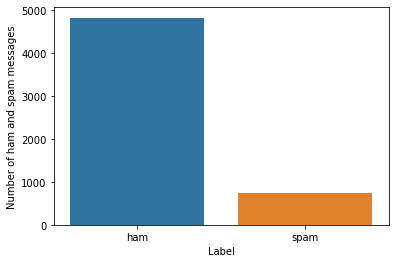

In [5]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.ylabel('Number of ham and spam messages')

### Y 값을 0, 1로 변환 : LabelEncoder()

In [6]:
X = df.v2
Y =df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)   # Y 값이 0,1로 변환, Logistic Regression, sigmoid사용
Y = Y.reshape(-1,1)       # 2차원
print(Y.shape)

(5572, 1)


In [7]:
### train 과 test 데이터 셋으로 분리
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)  # 70:30
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(3900,) (1672,) (3900, 1) (1672, 1)


### 문장을 토큰화 처리, 패딩, 데이터셋의 길이를 설정

In [8]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

# tf.keras.preprocessing.text.Tokenizer(
#     num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,
#     split=' ', char_level=False, oov_token=None, document_count=0, **kwargs
# )

In [9]:
# 토큰나이저를 시행하여 단어를 숫자값, 인덱스로 변환하여 저장

max_words = 1000
max_len = 150         # 데이터 셋의 길이, 한 문장의 길이, sequence_length: T

tok = Tokenizer(num_words=max_words) # 가장 빈도가 높은 1000 개의 단어들만 사용하여 토큰화

# 단어 인덱스를 구축
tok.fit_on_texts(X_train)   # 범위 : 0 ~ 999

# 문자열을 정수 인덱스의 리스트로 변환
sequences = tok.texts_to_sequences(X_train) # type은 list
sequences[:4]      # 길이가 서로 다름

# 벡터 표현을 얻음
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)  # 신경망에 입력할 X값이다
print(sequences_matrix.shape)  # (3900, 150), 2차원 행렬

word_to_index = tok.word_index
# print(word_to_index)
vocab_size = len(word_to_index)
print(vocab_size)

sequences_matrix

(3900, 150)
7405


array([[  0,   0,   0, ...,   4, 134, 793],
       [  0,   0,   0, ...,  20, 154, 249],
       [  0,   0,   0, ...,   5, 358, 151],
       ...,
       [  0,   0,   0, ..., 137,  14, 957],
       [  0,   0,   0, ...,   3,  28,  57],
       [  0,   0,   0, ...,  11,  53,  79]])

## RNN 신경망 모델 구현

In [10]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
# tf.keras.layers.Embedding(
#     input_dim, output_dim, embeddings_initializer='uniform',
#     embeddings_regularizer=None, activity_regularizer=None,
#     embeddings_constraint=None, mask_zero=False, input_length=None, **kwargs
# )

# input_dim : input_dim   , D  , max_words : 1000
# output_dim : hidden_size , H , 50
# input_length : sequence_length , T : max_len:150

In [11]:
# LSTM 1층을 사용하여 신경망을 구현
# model = tf.keras.Sequential([
#     # (None,1000) * (1000,50) = (None,50) , T:150, (None,150,50)
#     tf.keras.layers.Embedding(max_words,50,input_length=max_len), # 3차원으로 출력, (None, 150, 50)
#     # (None,150,50), W: (D,H) ==>(50,32)  
#     # (None,50) * (50,32) = (None,32) -> (None,150,50) 
#     tf.keras.layers.LSTM(32,return_sequences=True),
#     # (None,50) * (50,32) = (None,32) -> (None,150,32) 
#     tf.keras.layers.Dense(32,activation='relu'),
#     tf.keras.layers.Dropout(rate=0.5),  # (None,150,32)  # 3차원 
#     tf.keras.layers.Flatten(),          # (None,150*32) = (None, 4800)  , 2차원
#     tf.keras.layers.Dense(1,activation='sigmoid') # (None,1)
# ])  

# model.summary()

In [12]:
# LSTM 2층 을 사용하여 신경망을 구현  :    [ Accuracy : 0.986 ]  # 2층의 정확도가 약간 높다
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words,50,input_length=max_len), # 3차원으로 출력, (None, 150, 50) 
    tf.keras.layers.LSTM(32,return_sequences=True),  # 3차원으로 출력, (None, 150, 32) 
    tf.keras.layers.LSTM(32),                        # 2차원으로 출력, (None,  32) 
    tf.keras.layers.Dense(32,activation='relu'),     # 2차원으로 출력,  None,  32)
    tf.keras.layers.Dropout(rate=0.5),               # 2차원으로 출력, (None,  32)
    # tf.keras.layers.Flatten(),                     
    tf.keras.layers.Dense(1,activation='sigmoid')    # 2차원으로 출력, (None, 1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 150, 32)           10624     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 70,033
Trainable params: 70,033
Non-trainable params: 0
____________________________________________________

In [13]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
# RMSProp : https://forensics.tistory.com/28
# RMSprop 알고리즘은 Adadelta와 마찬가지로 Adagrad에서 학습률이 급격하게 감소하는 문제를 해결 

In [14]:
# 학습
model.fit(sequences_matrix,Y_train,batch_size=128, epochs=10, validation_split=0.2)

Train on 3120 samples, validate on 780 samples
Epoch 1/10
3120/3120 [==============================] - 17s 6ms/sample - loss: 0.3635 - accuracy: 0.8638 - val_loss: 0.2039 - val_accuracy: 0.9372
Epoch 2/10
3120/3120 [==============================] - 9s 3ms/sample - loss: 0.1645 - accuracy: 0.9545 - val_loss: 0.1233 - val_accuracy: 0.9731
Epoch 3/10
3120/3120 [==============================] - 9s 3ms/sample - loss: 0.1112 - accuracy: 0.9827 - val_loss: 0.0950 - val_accuracy: 0.9846
Epoch 4/10
3120/3120 [==============================] - 9s 3ms/sample - loss: 0.0702 - accuracy: 0.9869 - val_loss: 0.0658 - val_accuracy: 0.9872
Epoch 5/10
3120/3120 [==============================] - 9s 3ms/sample - loss: 0.0531 - accuracy: 0.9901 - val_loss: 0.0638 - val_accuracy: 0.9885
Epoch 6/10
3120/3120 [==============================] - 9s 3ms/sample - loss: 0.0385 - accuracy: 0.9926 - val_loss: 0.0909 - val_accuracy: 0.9846
Epoch 7/10
3120/3120 [==============================] - 9s 3ms/sample - loss

### 정확도 측정

In [15]:
#  Test 데이터셋의 벡터를 구함

# 문자열을 정수 인덱스의 리스트로 변환
test_sequences = tok.texts_to_sequences(X_test) 

# 벡터 표현을 얻음
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)  # 신경망에 입력할 X값이다
print(test_sequences_matrix.shape,Y_test.shape)  # (1672, 150), 2차원 행렬

(1672, 150) (1672, 1)


In [16]:
# 정확도
accr = model.evaluate(test_sequences_matrix,Y_test) 

1672/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [17]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.061
  Accuracy: 0.986


In [18]:
# 예측
preds = model.predict(test_sequences_matrix[1].reshape(1,-1)) # test_sequences_matrix[1]은 1차원이므로
preds,Y_test[1]

(array([[4.973708e-06]], dtype=float32), array([0]))

In [19]:
test_sequences_matrix[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0, 161,  11, 924,  52,
        15, 477,  23, 226, 223,   1,  54])

In [20]:
preds = model.predict(test_sequences_matrix[17].reshape(1,-1)) 
preds,Y_test[17]

(array([[2.5730735e-05]], dtype=float32), array([0]))

In [21]:
ones = np.where(Y_test==1)  # 답이 1인 인덱스
ones[0]

array([   7,    8,   16,   31,   35,   45,   46,   52,   53,   63,   65,
         73,   83,   87,  122,  132,  133,  136,  138,  149,  152,  161,
        163,  169,  171,  174,  185,  186,  196,  200,  202,  206,  207,
        213,  246,  262,  296,  301,  310,  319,  321,  329,  333,  345,
        346,  359,  381,  384,  421,  438,  439,  455,  456,  457,  461,
        469,  476,  478,  485,  496,  497,  528,  530,  532,  536,  567,
        587,  593,  599,  627,  632,  633,  637,  643,  655,  659,  661,
        679,  686,  710,  711,  716,  718,  724,  725,  733,  736,  743,
        749,  750,  752,  754,  757,  769,  776,  777,  778,  780,  790,
        804,  814,  832,  835,  849,  851,  853,  866,  875,  878,  879,
        885,  895,  922,  925,  933,  950,  966,  975,  977,  986,  988,
       1003, 1007, 1008, 1011, 1014, 1022, 1036, 1059, 1073, 1080, 1089,
       1090, 1097, 1113, 1118, 1130, 1134, 1159, 1162, 1163, 1165, 1167,
       1170, 1179, 1181, 1185, 1188, 1195, 1204, 12

In [22]:
for one in ones[0]:
    preds = model.predict(test_sequences_matrix[one].reshape(1,-1))
    print(preds,Y_test[one])

[[0.99945277]] [1]
[[0.9994854]] [1]
[[0.8233976]] [1]
[[0.9941346]] [1]
[[0.9968148]] [1]
[[0.99962056]] [1]
[[0.9995414]] [1]
[[0.9995921]] [1]
[[0.99536186]] [1]
[[0.99952793]] [1]
[[0.9991917]] [1]
[[0.99963224]] [1]
[[2.1189595e-05]] [1]
[[0.99963975]] [1]
[[0.99953973]] [1]
[[0.9995789]] [1]
[[0.99957865]] [1]
[[0.99908435]] [1]
[[0.9995427]] [1]
[[0.9995933]] [1]
[[0.99953854]] [1]
[[0.9993505]] [1]
[[0.9995838]] [1]
[[0.00014571]] [1]
[[0.9994929]] [1]
[[0.99951804]] [1]
[[0.99931324]] [1]
[[0.9994456]] [1]
[[0.9995968]] [1]
[[0.9989832]] [1]
[[0.9996543]] [1]
[[0.05111113]] [1]
[[0.9993636]] [1]
[[0.9995702]] [1]
[[0.90353256]] [1]
[[0.99949014]] [1]
[[0.8528395]] [1]
[[0.99943024]] [1]
[[0.99904126]] [1]
[[0.99955016]] [1]
[[7.1478016e-06]] [1]
[[0.9994168]] [1]
[[0.9996178]] [1]
[[0.9974088]] [1]
[[0.99960023]] [1]
[[0.99963427]] [1]
[[0.99950624]] [1]
[[0.9996307]] [1]
[[0.9995913]] [1]
[[0.99932003]] [1]
[[0.999166]] [1]
[[0.9992199]] [1]
[[0.9980477]] [1]
[[0.999551]] [1]